### Modules
- 🔌 load_ext: conecta módulos automaticamente
- 🔁 autoreload 2: actualiza resultados de load_ext a cada celda

In [38]:
%load_ext autoreload 
%autoreload 2 

>>> registering accessor 'missing'
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/jayrd/wks-git/data_science_portfolio/ds_missing_data/src/core/implementations/null_report_run.py:69: UserWarning: registration of accessor <class 'src.core.implementations.null_report_run.MissingAccessor'> under name 'missing' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("missing")


### RootPath: Set Working Directory to Project Root


In [39]:
from pathlib import Path
import os

class RootPath:
    def __init__(self, marker=".here", root="."):
        self.root = self.resolve(Path(root), marker)
        print(f"Now you are here: {self.root}")

    def resolve(self, start_path: Path, marker: str) -> str:
        search_path = start_path.resolve()
        for directory in [search_path] + list(search_path.parents):
            marker_path = directory / marker
            if marker_path.exists():
                return str(directory)

        raise FileNotFoundError(
            f"Marker file '{marker}' not found.\n"
            f"Please create a '{marker}' file at the project root.\n"
            f"Search started from: {search_path}\n"
        )

    def __str__(self):
        return self.root

# Create instance -> finds the project root
project_root = RootPath()
root_path = Path(str(project_root))

# Change the current working directory to the project root
os.chdir(root_path)

# Confirm current working directory
print("Current working directory:", Path.cwd())


Now you are here: /home/jayrd/wks-git/data_science_portfolio/ds_missing_data
Current working directory: /home/jayrd/wks-git/data_science_portfolio/ds_missing_data


In [40]:
from pyhere import here
import os
from pathlib import Path

# Set project root using .here marker
os.chdir(here())

# Confirm current working directory
print("Current working directory:", Path.cwd())


Current working directory: /home/jayrd/wks-git/data_science_portfolio/ds_missing_data


In [ ]:
import pandas
dic = {
            'a': [1,2,3,5],
            'b': [1,2,3,5],
            'c': [1,2,3,5]
        }
        pandas.DataFrame(dic, columns=[dic.keys])

In [41]:
import pandas as pd
import numpy as np
import ydata_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import missingno 


# Implementations
from src.core.implementations.sample_run import SampleDF
from src.core.implementations.correlation_columns_run import CorrColumns
from src.core.implementations.corr_filterproxy_run import CorrFilterProxy
from src.core.implementations.corr_plotter_run import CorrPlotter
import src.core.implementations.null_report_run #missing accesor Implt
import src.core.implementations.plotx_chart_run #missing accesor Implt
from src.core.implementations.single_val_run import SingleValues
from src.core.implementations.shadow_imputer_run import ShadowImputer



#### Load data with pre-normalization for missing values

In [42]:
# Build the file path in a way that works across different operating systems
csv_path_ocean = os.path.join(os.getcwd(), "data", "ocean.csv")

common_na_strings = [
    "missing", "NA", "N A", "N/A", "#N/A", "NA ", " NA", "N /A", "N / A", " N / A",
    "N / A ", "na", "n a", "n/a", "na ", " na", "n /a", "n / a", " a / a", "n / a ",
    "NULL", "null", "", "?", "*", "."
]
common_na_numbers = [-9, -99, -999, -9999, 9999, 66, 77, 88, -1]

df_original = pd.read_csv(csv_path_ocean, na_filter=True, na_values=common_na_numbers+common_na_strings)
df_original = df_original.iloc[:, 1:] #Elimina columna Unnamed: 0'
df = df_original.copy(deep=True)


### Summary table for missing data overview

In [ ]:
summary_table = df.missing.summary()
display(summary_table)



To visualize correlation plots, refer to:
correlation_columns_run.py, corr_filterproxy_run.py, and corr_plotter_run.py
If you're using a Jupyter notebook, run this with display(summary)


,variable,n_missing,missing,n_cases,n_unique,common_value,max_n,median,min_n,range_n,pct_missing,is_const,is_numeric,high_correlation,dtype
0,year,0,0,736,2,1997.00,1997.00,1995.0000,1993.00,4.00,0.0000,False,True,True,float64
1,latitude,0,0,736,3,0.00,0.00,-1.3750,-5.00,5.00,0.0000,False,True,True,float64
2,longitude,0,0,736,2,-110.00,-95.00,-102.5000,-110.00,15.00,0.0000,False,True,True,float64
3,sea_temp_c,3,1,736,417,27.60,30.17,25.8650,21.60,8.57,0.4076,False,True,True,float64
4,air_temp_c,81,1,736,307,27.78,28.50,25.0293,21.42,7.08,11.0054,False,True,True,float64
5,humidity,102,1,736,164,87.50,94.80,84.4711,71.60,23.20,13.8587,False,True,False,float64
6,wind_ew,5,1,736,98,-4.40,4.30,-3.7345,-8.10,12.40,0.6793,False,True,True,float64
7,wind_ns,2,1,736,105,4.10,7.30,2.6456,-6.20,13.50,0.2717,False,True,False,float64


### DataFrame with random sample
### Recuerda: pueden exitir valores faltantes implicitos, intenta descubrirlos!


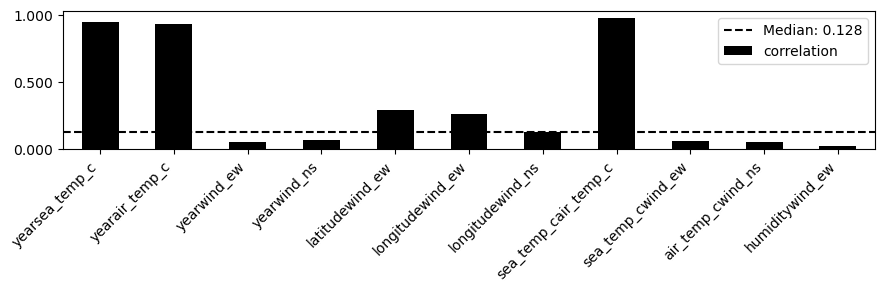

In [44]:
# Generate a DataFrame with pairwise correlations
correlations = CorrColumns(df=df) #df[df['year'] == 1997.0]

#Correlation table
corr_table = correlations.correlate_pairs()

#Top 5 in correlations columns
top_df = correlations.corr_top(top_n=5)

# Proxy class to validate and prepare the data for the plotter
# Apply a minimum correlation filter (e.g., 0.50 = only correlations > 50%) pct_filter_col=0.50
proxy = CorrFilterProxy(df=corr_table)
df_filtered = proxy.filter(pct_filter_col=0.9)  

# Plot correlations
plotter = CorrPlotter(df=df_filtered)
df_top = plotter.plot(color="black", show_median=True)

#corr_table.sort_values(by=['correlation'], ascending=True)
#Observaciones de columnas: 
# air_temp_c == 1997 
# humidity   == 1993

### DataFrame with random sample

In [45]:
"""
    Utility class to work with sample DataFrames.

    Behavior:
    - If only_sample=True → returns a sample DataFrame.
    - If only_sample=False → randomly checks values from each column 
      to ensure they match the declared dtype.
"""
df_sample = SampleDF(df=df, pct=0.5, only_sample=True).sample_dtype()
df_sample.sort_values(by="sea_temp_c", ascending=True)


,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
487,1993.0,0.0,-95.0,21.799999,21.730000,NaN,-1.8,2.7
473,1993.0,0.0,-95.0,21.860001,21.850000,NaN,-3.2,3.6
469,1993.0,0.0,-95.0,21.940001,21.969999,NaN,-0.8,4.8
470,1993.0,0.0,-95.0,21.969999,21.809999,NaN,-2.2,4.3
571,1993.0,-2.0,-95.0,21.990000,22.430000,85.199997,-3.5,5.2
...,...,...,...,...,...,...,...,...
178,1997.0,0.0,-95.0,29.559999,NaN,79.099998,-2.3,0.4
177,1997.0,0.0,-95.0,29.629999,NaN,76.300003,-0.4,-3.9
174,1997.0,0.0,-95.0,29.889999,NaN,74.500000,-3.0,-0.2
176,1997.0,0.0,-95.0,29.950001,NaN,78.000000,0.9,-4.0


### Profile report with ydata_profiling

In [46]:

profile1 = ydata_profiling.ProfileReport(df)
#profile1.to_file("outputs/reports/profile_report_ocean.html")


### Pueden existir valores faltantes disfrazados de no faltante (implicitos)

In [47]:
df_single_val = SingleValues(dataframe=df).extract_rare_values()
df_single = df_single_val[df_single_val["column"] == "sea_temp_c"]

display(df_single)

🔍 Rare value extraction complete.
🧹 Columns with at least one unique (non-repeating) value:
--->>>['sea_temp_c', 'air_temp_c', 'humidity', 'wind_ew', 'wind_ns']

📎 Reminder: Some columns may be omitted if no rare values were found.
🧪 For better visibility in Jupyter, use: display(dataframe)


,column,unique
0,sea_temp_c,27.830000
1,sea_temp_c,28.200001
2,sea_temp_c,24.299999
3,sea_temp_c,24.230000
4,sea_temp_c,24.600000
...,...,...
216,sea_temp_c,23.990000
217,sea_temp_c,24.059999
218,sea_temp_c,24.209999
219,sea_temp_c,25.120001


##### Missing At Random tests
- **air_temp_c (1997)** → 77 NA: sin patrones detectados  
- **humidity (1993)** → 95 NA: sin patrones detectados  

##### 🔗 Correlaciones altas
- `air_temp_c` ↔ `sea_temp_c`  
- `humidity` ↔ `wind_ew`, `wind_ns`  

##### 🧠 Ideas aplicadas
- Identificamos columnas con alta correlación por año  
- Aplicamos matriz shadow para visualizar patrones de ausencia  
- Identificamos que cuando falta air_temp_c la columna sea_temp_c esta presente 100%  


In [48]:
# Select the relevant temperature columns
df_temp = df[["air_temp_c", "sea_temp_c"]]

# Check for missing values and create logical flags
# Banderas con vectorizacion para mayor velocidad (df[col] & df[col])
na = df[["air_temp_c","sea_temp_c"]].isna()
df_temp = pd.DataFrame({
    "both_na": (na["air_temp_c"] &  na["sea_temp_c"]).astype(int),
    "only_air": (na["air_temp_c"] & ~na["sea_temp_c"]).astype(int),
    "only_sea": (na["sea_temp_c"] & ~na["air_temp_c"]).astype(int),
})
df_temp.sum()

#df_temp = df_temp[df_temp["only_air"] == 1]
#df.loc[df_temp.index]

df_temp[["both_na", "only_air", "only_sea"]].sum()

both_na      3
only_air    78
only_sea     0
dtype: int64

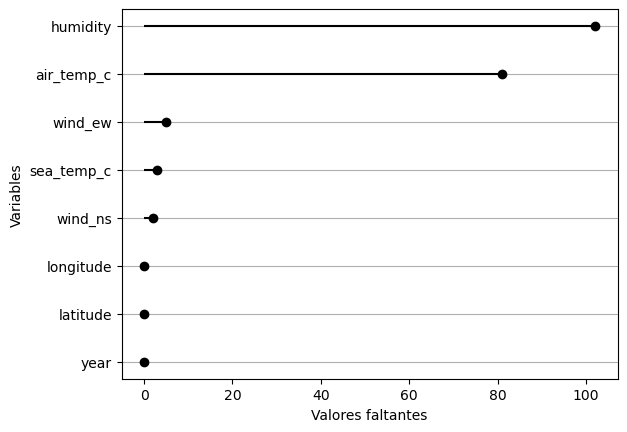

In [49]:
# Supongamos que ya tienes este DataFrame
summary_table = summary_table.sort_values("n_missing")

# Crear figura y eje
fig, ax = plt.subplots()
# Rango para el eje Y
plot_range = range(1, len(summary_table.index) + 1)

# Convertir a array por compatibilidad
xmax_values = np.array(summary_table['n_missing'])
# Dibujar líneas horizontales
ax.hlines(y=plot_range, xmin=0, xmax=xmax_values, color="black")
# Dibujar puntos
ax.plot(xmax_values, plot_range, "o", color="black")
# Etiquetas y estilo
ax.set_yticks(plot_range)
ax.set_yticklabels(summary_table['variable'])
ax.set_xlabel("Valores faltantes")
ax.set_ylabel("Variables")
ax.grid(axis="y")

plt.show()


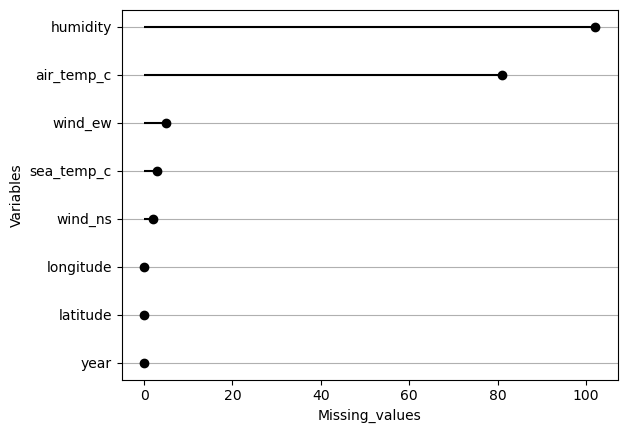

In [50]:
summary_table.plotx.pct_missing_chart()

In [ ]:
matrix_table = df.plotx.matrix_missing_chart(only_missing = False, 
                                             only_table=True, x='sea_temp_c_NA',
                                             y='air_temp_c_NA')

<Axes: xlabel='air_temp_c_NA', ylabel='sea_temp_c'>

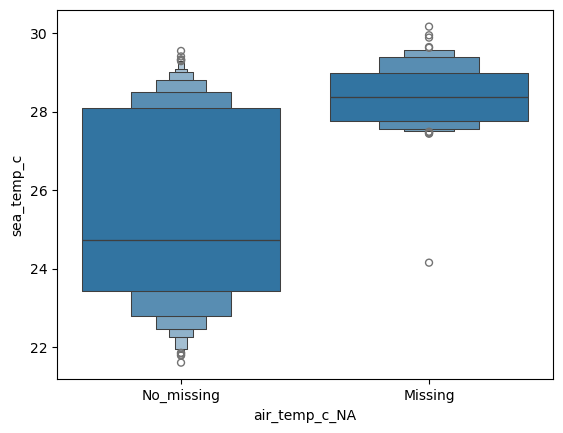

In [52]:
sns.boxenplot(
    data=matrix_table,
    x='air_temp_c_NA',
    y='sea_temp_c'
)


In [54]:
shw_imputer = ShadowImputer(column=df['air_temp_c'], proportion_below=0.10, jitter=0.075, seed=42)
air_temp_c_filled = shw_imputer.fill_with_dummies()


pd.DataFrame(matrix_table).assign(
    air_temp_c_filled = air_temp_c_filled
)



,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns,year_NA,latitude_NA,longitude_NA,sea_temp_c_NA,air_temp_c_NA,humidity_NA,wind_ew_NA,wind_ns_NA,air_temp_c_filled
0,1997.0,0.0,-110.0,27.590000,27.150000,79.599998,-6.4,5.4,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,27.150000
1,1997.0,0.0,-110.0,27.549999,27.020000,75.800003,-5.3,5.3,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,27.020000
2,1997.0,0.0,-110.0,27.570000,27.000000,76.500000,-5.1,4.5,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,27.000000
3,1997.0,0.0,-110.0,27.620001,26.930000,76.199997,-4.9,2.5,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,26.930000
4,1997.0,0.0,-110.0,27.650000,26.840000,76.400002,-3.5,4.1,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,26.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,1993.0,-2.0,-110.0,24.780001,24.620001,90.800003,-4.4,1.7,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,24.620001
732,1993.0,-2.0,-110.0,24.879999,24.500000,91.099998,-3.0,0.2,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,24.500000
733,1993.0,-2.0,-110.0,25.120001,24.889999,89.699997,-4.0,1.1,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,24.889999
734,1993.0,-2.0,-110.0,25.160000,24.930000,89.500000,-4.3,2.5,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,No_missing,24.930000


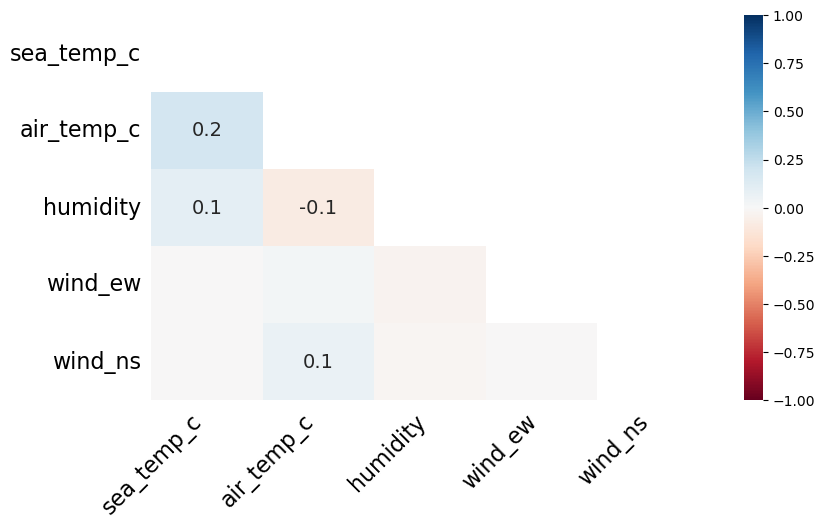

In [62]:
fig, ax = plt.subplots(figsize=(9,5))
missingno.heatmap(df=matrix_table, ax=ax)

plt.show()